# Imports

In [1]:
from fastai import *
from fastai.vision import *
import re
import os.path

# Data Gathering

Using CTRL-SHIFT-K to open the browser console, and then posting in this:

`urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));`

will generate CSV files with all the addresses of the images to download. Save these files in `csv_path`, and designate a `data_path` where the images will be stored. 

In [2]:
data_path = Path('/media/andrew/Data/BirdsofAL')
csv_path = Path('/home/andrew/Code/repos/BirdsofAL/image_csvs')
#Path??

# Setup
### Only needs to be performed one time

In [3]:
classes = []

In [5]:
csv_path.ls()

[PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Summer_Tanager.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Barn_Swallow.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Eastern_Bluebird.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Brown_Pelican.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/American_Robin.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/American_Goldfinch.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Northern_Cardinal.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Cedar_Waxwing.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Bald_Eagle.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Blue_Jay.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Great_Blue_Heron.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/image_csvs/Red-winged_Blackbird.csv'),
 PosixPath('/home/andrew/Code/repos/BirdsofAL/ima

In [6]:
# # make all folders and download all pictures
# # Note: don't need to rerun if already run
for file in csv_path.iterdir():
    file = os.path.basename(file)
    clas = file.rstrip(".csv")
    classes.append(clas)
#     dest = data_path/clas
#     dest.mkdir(parents=True, exist_ok=True)
#     download_images(csv_path/file, dest, max_pics=200)

In [7]:
classes

['Summer_Tanager',
 'Barn_Swallow',
 'Eastern_Bluebird',
 'Brown_Pelican',
 'American_Robin',
 'American_Goldfinch',
 'Northern_Cardinal',
 'Cedar_Waxwing',
 'Bald_Eagle',
 'Blue_Jay',
 'Great_Blue_Heron',
 'Red-winged_Blackbird',
 'Killdeer',
 'Barred_Owl',
 'Indigo_Bunting',
 'White-breasted_Nuthatch',
 'Brown_Headed_Nuthatch',
 'American_Crow',
 'Hooded_Warbler',
 'Northern_Mockingbird',
 'Carolina_Chickadee']

In [8]:
for c in classes:
    verify_images(data_path/c, delete=True, max_size=500)

# View Data

In [9]:
np.random.seed(1)
data = ImageDataBunch.from_folder(path=data_path, valid_pct=0.2, 
                                  ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [10]:
# If you already cleaned your data, run this cell instead of the one before
# np.random.seed(1)
# data = ImageDataBunch.from_csv(".", folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#                                 ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [11]:
data.c

21

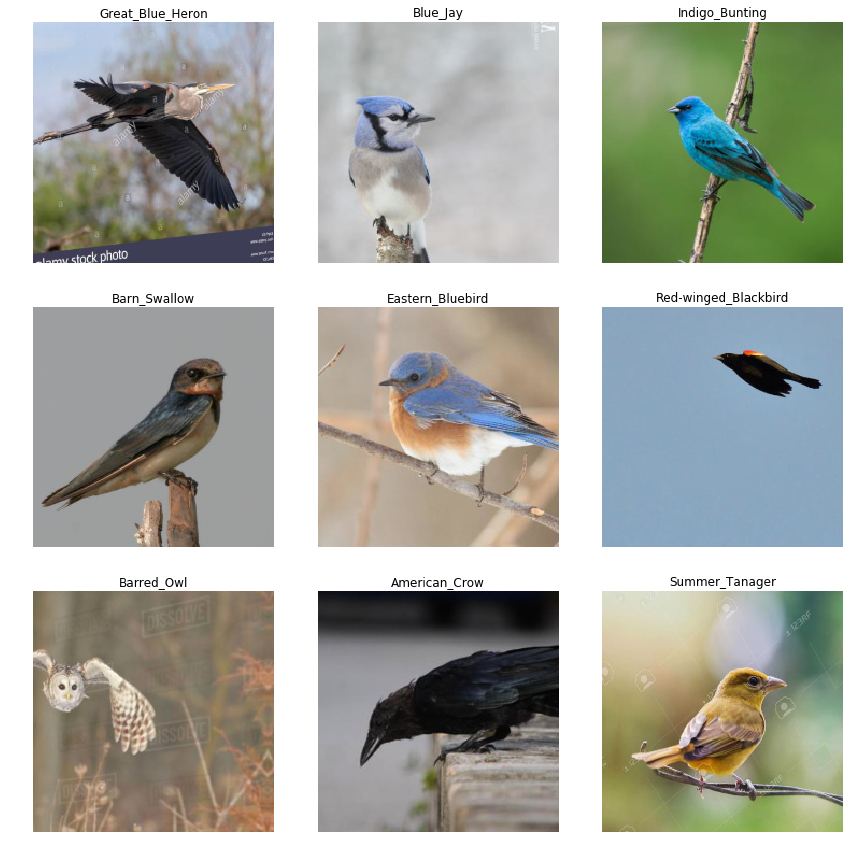

In [12]:
data.show_batch(rows=3)

In [13]:
print(" Training dataset size:", len(data.train_ds), '\n', "Validation dataset size:", len(data.valid_ds))

 Training dataset size: 2621 
 Validation dataset size: 655


In [14]:
data.export()

# Create CNN & Begin Training

In [ ]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(5)

In [ ]:
learn.save('stage-1')

The model very quickly achieves >93% accuracy.

In [ ]:
learn.load('stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

# Continue Training

In [ ]:
learn.freeze()

In [ ]:
learn.fit_one_cycle(2, max_lr=slice(9e-3))

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(9e-3))

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(6e-3))

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(6e-5, 6e-4))

In [ ]:
learn.save('/home/andrew/Code/repos/BirdsofAL/trained_model/stage-2')

In [ ]:
learn.load('/home/andrew/Code/repos/BirdsofAL/trained_model/stage-2')

It seems like we are getting a little closer to having a good model. Let's to check what our bad actors are.

# Interpretation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_confusion_matrix(figsize=(25,25))

It seems like the system generally does well. Some confusion of Red-winged BB vs. American Crow

In [ ]:
interp.plot_top_losses(4)

Let's analyze some typical mistakes:
1. Not a typical looking birds for their species.
2. It predicted American Crow, whereas the real bird is a Cedar Waxwing. Those two birds look nothing alike, so it is good that the probability of American Crow is essentially 0. Typically the pictures used show the bird looking much more majestic. The tailfeathers and black around the eye, however, are distinctly Waxwing, so I'm not sure why this is performing so poorly.
3. Hard to tell if this is an American Crow or a RWBB even to a human eye, when the red is not visible. 
4. Sketches and non-photo images are pretty common.

# Cleaning Up

Overall, it seems like the prediction is going really well. When downloading the dataset, I noticed a few images that weren't actually photos of birds directly. You only need to run ImageCleaner if you brought in raw photos, and need to sort some out.

In [ ]:
from fastai.widgets import *

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [ ]:
# if you want to create a new dataset with only certain images
top_errors = data.valid_ds.x.items[idxs] # reorganize to have top losses first
top_errors

In [ ]:
ImageCleaner(ds, idxs)

To improve the dataset, it would be best to delete bird sketches, and a photos that were either of multiple birds, or not of birds. Leaving in bad photos or cell-phone camera photos will help to expand this to include personally shot photos.

# Running a bit more

Now to unfreeze to train lower layers.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-5))

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-5))

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-5))

In [ ]:
learn.save('/home/andrew/Code/repos/BirdsofAL/trained_model/stage-3')

In [ ]:
interp2 = ClassificationInterpretation.from_learner(learn)
interp2.plot_top_losses(4)

In [ ]:
learn.get_preds()[0][0]

Still having trouble on some of the same images.

One more comment:
1. Red-winged Blackbird Males and females look different. It is maybe not that impressive that the classifier has learned that both are the same class, but it is interesting.
![Red-winged Blackbird](http://www.paulnoll.com/Oregon/Birds/Home/birds-Blackbird-Red-winged.jpg "Red-winged Blackbird")